In [1]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib.path as mpath

import pandas as pd 

import gsw
%matplotlib inline

In [2]:
# A function that makes xy grid
def make_grid_xy(nx, ny, Lx, Ly):
    dx, dy = Lx/nx, Ly/ny  # Calculate grid spacing

    # Create mesh-grids for cell centers
    xc, yc = np.meshgrid(
        dx * np.arange(nx) + dx/2,  # Create x-coordinates for cell centers
        dy * np.arange(ny) + dy/2   # Create y-coordinates for cell centers
    )

    return xc, yc

In [3]:
res = 1.E3  # model resolution

Lx = 512*1.E3  # domain size x
Ly = 512*1.E3  # domain size y

nx = int(Lx/res)  # 512
ny = int(Ly/res)  # 512

In [4]:
xc, yc = make_grid_xy(nx, ny, Lx, Ly)

dx = xc[0,1] - xc[0,0]
dy = yc[1,0] - yc[0,0]
print(f"dx: {dx}, dy: {dy}, nx: {len(xc[0, :])}, ny: {len(yc[:, 0])}") 

# Print the shapes of xc and yc arrays
print("Shape of xc:", xc.shape)  
print("Shape of yc:", yc.shape) 

dx: 1000.0, dy: 1000.0, nx: 512, ny: 512
Shape of xc: (512, 512)
Shape of yc: (512, 512)


# Bathymetry

In [5]:
Ho = 1000

h = -Ho * np.ones((nx, ny))

# Walls (surrounding domain); generate bathymetry file
#h[:, [0,-1]] = 0   # set ocean depth to zero at east and west walls
h[[0], :] = 0   # set ocean depth to zero at south  wall
h[[nx-1], :] = 0   # set ocean depth to zero at north  wall
# save as single-precision (float32) with big-endian byte ordering
h.astype('>f4').tofile('bathy.KM.bin')

In [6]:
h.shape

(512, 512)

In [7]:
h[[0,-1],:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Wind

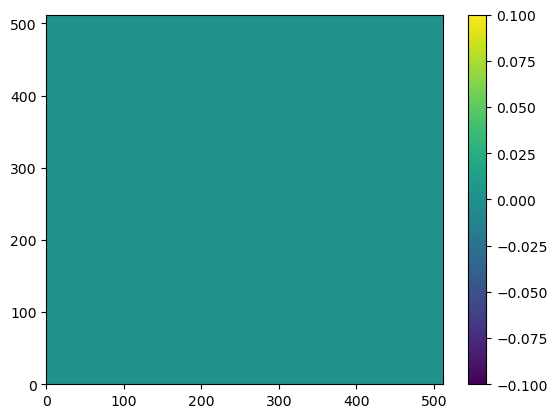

In [8]:
tau0 = 0.0

# everything is 0
tau = np.zeros([nx,ny])

tau.astype('>f4').tofile('wind.KM.bin')

plt.pcolor(tau)
plt.colorbar()

In [9]:
tau.shape

(512, 512)

# Heat flux

In [14]:
#Ho = 0.0

#h = Ho * np.ones((n, n))

# Walls (surrounding domain); generate bathymetry file
#h[:, [0,-1]] = 0   # set ocean depth to zero at east and west walls
#h[[0], :] = 0   # set ocean depth to zero at south  wall
# save as single-precision (float32) with big-endian byte ordering
#h.astype('>f4').tofile('heat_flux.bin')

# Depth levels

In [10]:
delR = np.array([5.0, 5.0, 5.0, 5.0, 
        5.0, 6.0, 6.0, 6.0, 
        6.0, 6.0, 8.0, 8.0, 
        8.0, 8.0, 8.0, 10.0, 
        10.0, 10.0, 10.0, 10.0,
        15.0, 15.0, 15.0, 15.0, 
        15.0, 20.0, 20.0, 20.0, 
        20.0, 20.0, 25.0, 25.0, 
        25.0, 25.0, 25.0, 30.0, 
        30.0, 30.0, 30.0, 30.0,
        35.0, 35.0, 35.0, 45.0, 
        45.0, 45.0, 55.0, 55.0, 
        55.0])
Z = -(delR.cumsum())

In [11]:
delR

array([ 5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8., 10., 10., 10., 10., 10., 15., 15., 15., 15., 15., 20.,
       20., 20., 20., 20., 25., 25., 25., 25., 25., 30., 30., 30., 30.,
       30., 35., 35., 35., 45., 45., 45., 55., 55., 55.])

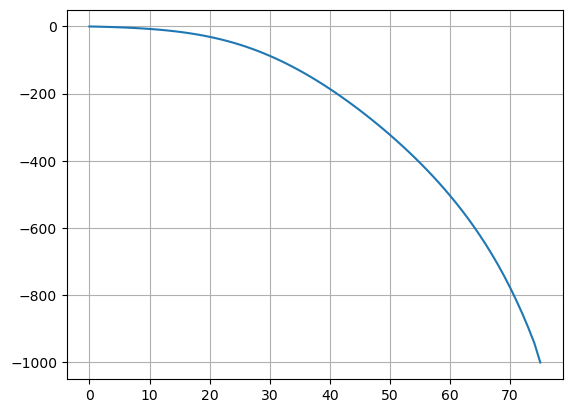

In [12]:
plt.plot(Z)
plt.grid('on')

# 3D Temperature 

In [12]:
## Overly complicated getting initial T profs N and S

nx = 512
ny = 512
nr = len(delR)
rF = (np.insert(np.cumsum(delR),0,0))
z = np.diff(rF)/2 + rF[:-1]
H = -np.sum(delR) 

temp_mid = 17.63666422
temp_mid_min = 16.81307022
Tmin = 0.90 * temp_mid   # north
Tmax = 1.10 * temp_mid   # south
Tmin_int = 0.90 * temp_mid_min

T_surf = np.tile(np.linspace(Tmin, Tmax, ny), (nx,1)).T
T_surf.astype('>f4').tofile('sst_relax.KM.bin')

h = 100             # e-folding scale for temperature decrease with depth
#T_surf = sst_relax  # use 2-D SST relaxation field for surface values
zscale = (np.exp(-z/h) - np.exp(H/h)) / (1 - np.exp(H/h))
#ztop = np.ones((18,))
#zscale = np.concatenate((ztop,zscale))
zscale = np.reshape(zscale[0:nr], [nr,1,1])
T_3D = np.reshape(T_surf - Tmin_int, [1,ny,nx]) * zscale + Tmin_int


T_3D[-1:-5,:,:] = Tmin_int

In [13]:
#tau0 = 128

# make sure that the northern point has zero winds
y = np.zeros([nx,])
x = np.arange(0, nx, 1)
meander = 5*np.sin(2*np.pi*(x)/nx) + 2 * np.random.random(nx)
y_F = np.ceil(meander)

In [14]:
x.shape

(512,)

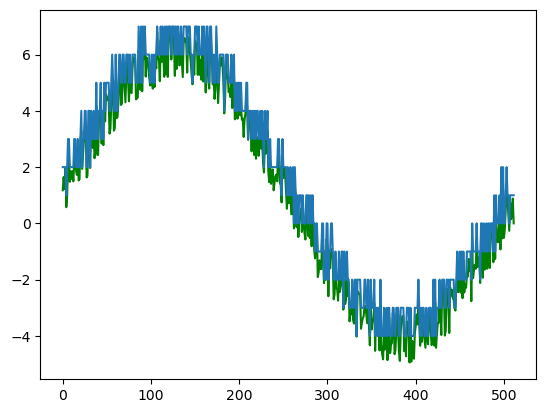

In [16]:
# Plotting the meander for visualization
plt.plot(x,meander, color='green')
plt.plot(x, y_F)
plt.show()

In [15]:
T_front = np.ones((nr,ny,nx))

T_S = T_3D[:,0,:]
T_N = T_3D[:,-1,:]
print(T_S, T_N)

for i in np.arange(0,ny,1):
    A = ((T_N-T_S))*((np.tanh(((i-(y_F+(ny/2)))/25))+1)/2)+T_S
    T_front[:,i,:] = A
    
T_front.astype('>f4').tofile('temperature_noML.KM.bin')

[[15.85469582 15.85469582 15.85469582 ... 15.85469582 15.85469582
  15.85469582]
 [15.81943634 15.81943634 15.81943634 ... 15.81943634 15.81943634
  15.81943634]
 [15.78589648 15.78589648 15.78589648 ... 15.78589648 15.78589648
  15.78589648]
 ...
 [15.13186265 15.13186265 15.13186265 ... 15.13186265 15.13186265
  15.13186265]
 [15.13180634 15.13180634 15.13180634 ... 15.13180634 15.13180634
  15.13180634]
 [15.13177385 15.13177385 15.13177385 ... 15.13177385 15.13177385
  15.13177385]] [[19.29493455 19.29493455 19.29493455 ... 19.29493455 19.29493455
  19.29493455]
 [19.09188484 19.09188484 19.09188484 ... 19.09188484 19.09188484
  19.09188484]
 [18.89873797 18.89873797 18.89873797 ... 18.89873797 18.89873797
  18.89873797]
 ...
 [15.1323359  15.1323359  15.1323359  ... 15.1323359  15.1323359
  15.1323359 ]
 [15.13201163 15.13201163 15.13201163 ... 15.13201163 15.13201163
  15.13201163]
 [15.13182454 15.13182454 15.13182454 ... 15.13182454 15.13182454
  15.13182454]]


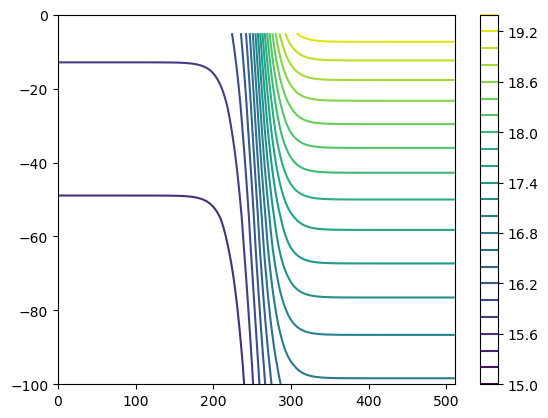

In [16]:
plt.contour(np.arange(0,ny,1),Z,T_front[:,:,128],levels=20)
#plt.clim([8.5,11.5])
plt.ylim(-100,0)
plt.colorbar()
#plt.gca().invert_yaxis()

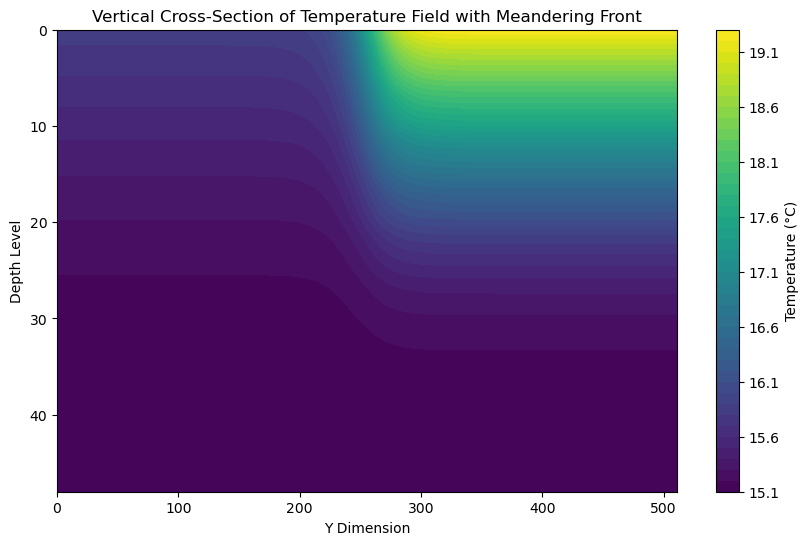

In [17]:
plt.figure(figsize=(10, 6))
plt.contourf(T_front[:, :, nx//2], levels=50, cmap='viridis')  # Cross-section at the middle of the x-dimension
plt.colorbar(label='Temperature (°C)')
plt.title('Vertical Cross-Section of Temperature Field with Meandering Front')
plt.xlabel('Y Dimension')
plt.ylabel('Depth Level')
plt.gca().invert_yaxis()  # Invert y-axis to have depth increasing downwards
plt.show()

## edit ML

In [20]:
# T_surf = T_front[0,:,:]
# ML = T_surf*np.ones((10,ny,nx)) #og 22

# fullT = np.concatenate((ML, T_front),axis=0)
# T_1000m = fullT[0:nr,:,:]
# #
# T_1000m.astype('>f4').tofile('temperature.KM.bin')

In [18]:
T_surf = T_front[0,:,:]
ML = T_surf*np.ones((5,ny,nx)) #og 22

fullT = np.concatenate((ML, T_front),axis=0)
T_1000m = fullT[0:nr,:,:]

T_1000m.astype('>f4').tofile('temperature.KM.bin')
# T_3000m.astype('>f4').tofile('temperature_w_meanderingfront.bin')

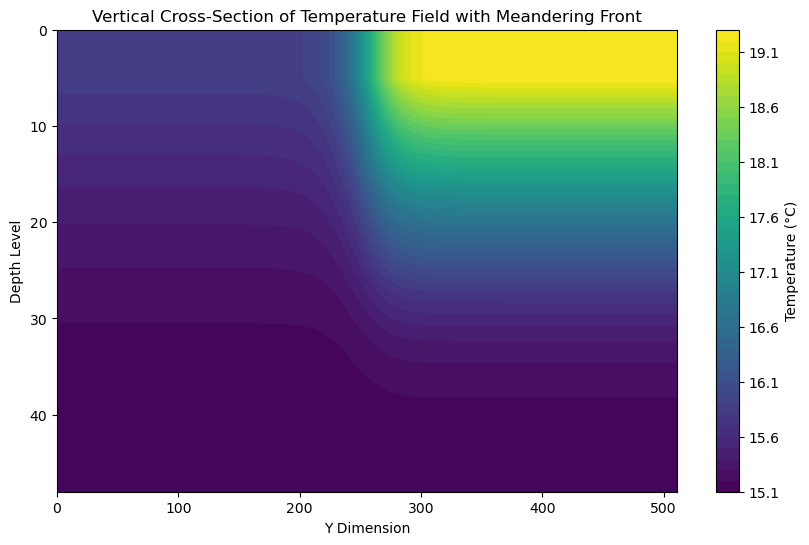

In [19]:
plt.figure(figsize=(10, 6))
plt.contourf(T_1000m[:, :, nx//2], levels=50, cmap='viridis')  # Cross-section at the middle of the x-dimension
plt.colorbar(label='Temperature (°C)')
plt.title('Vertical Cross-Section of Temperature Field with Meandering Front')
plt.xlabel('Y Dimension')
plt.ylabel('Depth Level')
plt.gca().invert_yaxis()  # Invert y-axis to have depth increasing downwards
plt.show()

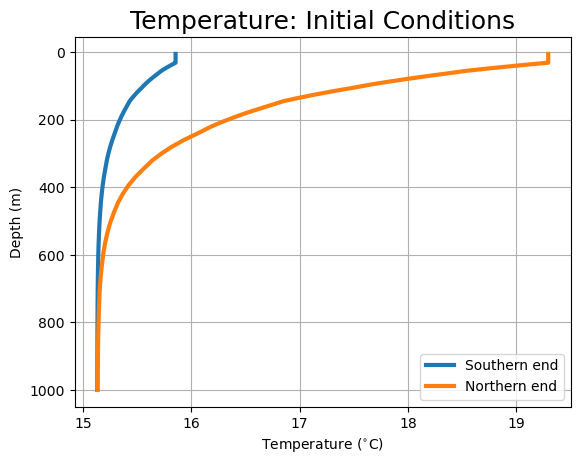

In [20]:
plt.plot(T_1000m[:,1,1], -Z, linewidth=3, label='Southern end')
#plt.plot(T_1000m[:,100,1], -Z)
#plt.plot(T_3D[:,1,0],-Z)
plt.plot(T_1000m[:,-1,1], -Z, linewidth=3, label='Northern end')
#plt.plot(T_1000m[:,-100,1], -Z)
#plt.plot(T_3000m[:,100,1], -Z, linewidth=3, label='mid')
#plt.plot(T_3D[:,20,1], pres)
plt.legend()
plt.grid()
#plt.ylim(100,300)
plt.xlabel('Temperature ($^{\circ}$C)')
plt.ylabel('Depth (m)')
plt.title('Temperature: Initial Conditions', fontsize=18);
plt.gca().invert_yaxis()

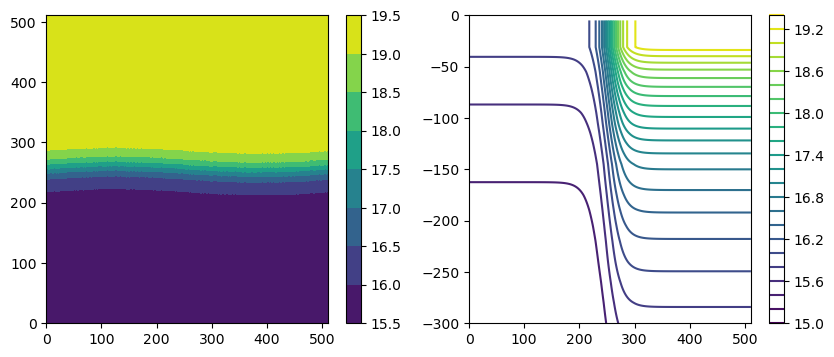

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.contourf(T_1000m[0,:,:])
#plt.clim([8.5,11.5])
plt.colorbar()

plt.subplot(122)
plt.contour(np.arange(0,ny,1),Z,T_1000m[:,:,int(nx/2)],levels=20)
plt.ylim(-300,0)
#plt.clim([8.5,11.5])
plt.colorbar()


## hyperbolic tangent

# PTRACERS

In [4]:
import numpy as np
import os


In [8]:
# Function to process each .init file
def process_init_file(filepath, target_depths, output_dir):
    # Load data from the .init file
    data = np.loadtxt(filepath)

    # Extract depths and values
    init_depths = data[:, 0]
    init_values = data[:, 1]

    # Interpolating values for the target depth levels
    target_values = np.interp(target_depths, init_depths, init_values)

    # Ensuring the first five levels have the same value
    target_values[:5] = target_values[0]

    # Creating the 3D array with shape (49, 512, 512)
    #initial_conditions = np.tile(target_values[:, np.newaxis, np.newaxis], (1, 512, 512))
   
    target_values_reshaped = target_values[:, np.newaxis]
    print(target_values_reshaped)


    # Save the initial conditions to a binary file
    filename = os.path.basename(filepath).replace('.init', '_ref_values.bin')
    output_path = os.path.join(output_dir, filename)
    # Save as binary file
    #initial_conditions.astype('float32').tofile(output_path)
    target_values_reshaped.astype('float32').tofile(output_path)

    print(f"Processed {filepath} and saved to {output_path}")

In [9]:
# Directory containing the .init files
input_dir = '/users/kmerk/experiments/KatarinaBATS_2/input/Kim_init_files'
output_dir = '/users/kmerk/experiments/KatarinaBATS_2/input/'

# Desired depth levels for the new initial conditions
target_depths = np.array([5.0, 10.0, 15.0, 20.0, 25.0, 31.0, 37.0, 43.0, 49.0, 55.0, 63.0, 71.0, 79.0, 87.0, 95.0, 
                          105.0, 115.0, 125.0, 135.0, 145.0, 160.0, 175.0, 190.0, 205.0, 220.0, 240.0, 260.0, 280.0, 
                          300.0, 320.0, 345.0, 370.0, 395.0, 420.0, 445.0, 475.0, 505.0, 535.0, 565.0, 595.0, 630.0, 
                          665.0, 700.0, 745.0, 790.0, 835.0, 890.0, 945.0, 1000.0])



In [10]:
# Loop through all .init files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.init'):
        filepath = os.path.join(input_dir, filename)
        process_init_file(filepath, target_depths, output_dir)


[[0.2639  ]
 [0.2639  ]
 [0.2639  ]
 [0.2639  ]
 [0.2639  ]
 [0.263708]
 [0.263516]
 [0.263324]
 [0.263132]
 [0.26342 ]
 [0.263932]
 [0.264444]
 [0.26654 ]
 [0.27022 ]
 [0.2739  ]
 [0.27138 ]
 [0.26174 ]
 [0.2521  ]
 [0.22982 ]
 [0.20754 ]
 [0.18672 ]
 [0.1722  ]
 [0.16512 ]
 [0.15812 ]
 [0.15128 ]
 [0.12908 ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]
 [0.1158  ]]
Processed /users/kmerk/experiments/KatarinaBATS_2/input/Kim_init_files/BATS_BAc.init and saved to /users/kmerk/experiments/KatarinaBATS_2/input/BATS_BAc_ref_values.bin
[[0.04582  ]
 [0.04582  ]
 [0.04582  ]
 [0.04582  ]
 [0.04582  ]
 [0.04582  ]
 [0.04582  ]
 [0.04582  ]
 [0.04582  ]
 [0.045824 ]
 [0.0458304]
 [0.0458368]
 [0.0463264]
 [0.0472992]
 [0.048272 ]
 [0.048368 ]
 [0.047344 ]
 [0.04632  ]
 [0.04232

Processed /users/kmerk/experiments/KatarinaBATS_2/input/Kim_init_files/BATS_SPp.init and saved to /users/kmerk/experiments/KatarinaBATS_2/input/BATS_SPp_ref_values.bin
[[3.853000e-16]
 [3.853000e-16]
 [3.853000e-16]
 [3.853000e-16]
 [3.853000e-16]
 [3.831400e-16]
 [3.809800e-16]
 [3.788200e-16]
 [3.766600e-16]
 [3.155780e-16]
 [2.184228e-16]
 [1.212676e-16]
 [6.356200e-17]
 [4.530600e-17]
 [2.705000e-17]
 [1.398880e-17]
 [1.068640e-17]
 [7.384000e-18]
 [6.295200e-18]
 [5.206400e-18]
 [3.933600e-18]
 [2.841000e-18]
 [2.293800e-18]
 [1.776600e-18]
 [1.319400e-18]
 [8.368200e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]
 [6.167000e-19]]
Processed /users/kmerk/experiments/KatarinaBATS